<a href="https://colab.research.google.com/github/hkyoo52/GAN/blob/main/GAN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
import numpy as np
from matplotlib import pyplot as plt

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

In [ ]:
# 하이퍼 파라미터
batch_size = 128
img_rows=28
img_cols=28
channels=1

img_shape=(img_rows,img_cols,channels)

z_dim=100

In [ ]:
# MNIST DATASET

# standardization code
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.5],std=[0.5])])  # 만약 RGB이면 (0.5,0.5,0.5)


# 데이터 불러오기
mnist_train = torchvision.datasets.MNIST(root='data/',train=True, transform=transform,download=True)
mnist_test  = torchvision.datasets.MNIST(root='data/', train=False,transform=transform,download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



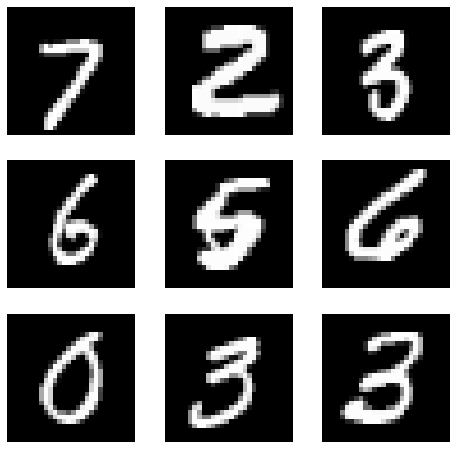

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_train), size=(1,)).item()
    img, label = mnist_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off") # x축, y축 안보이게 설정
    plt.imshow(img.squeeze(), cmap="gray")
plt.show() 

In [ ]:
# Data Loader
# 파이토치는 dataset에 정답과 라벨을 붙이고, Dataloader로 쉽게 불러올 수 있게 한다.
data_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True)

In [ ]:
# 생성자 모델
class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.z = params['z'] # 입력 노이즈 벡터 수, 100
        self.img_size = params['img_size'] # 이미지 크기, 1x28x28

        self.model = nn.Sequential(
            nn.Linear(self.z, 128,),
            nn.LeakyReLU(0.01),
            nn.Linear(128,128 ),
            nn.LeakyReLU(0.01),
            nn.Linear(128,int(np.prod(self.img_size))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_size) # 28,28,1 크기로 바꿈
        return img

In [ ]:
# 판별자 코드

class Discriminator(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.img_size = params['img_size'] # 이미지 크기, 1x28x28

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(self.img_size)), 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128,128 ),
            nn.LeakyReLU(0.01),
            nn.Linear(128,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        x = self.model(x)
        return x

In [ ]:
# 초기화

# 각 계층에 초기값을 적용해준다.
def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Linear') != -1:         # LeakyRelu 같은거에는 효과 적용 X하려고, 
      nn.init.normal_(model.weight.data, 0.0, 0.02)
      nn.init.constant_(model.bias.data, 0)

In [ ]:
# check
params = {'z':100,'img_size':(1,28,28)}

model_gen = Generator(params).to(device)
model_dis = Discriminator(params).to(device)
model_gen.apply(initialize_weights)
model_dis.apply(initialize_weights)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
from torch import optim

loss_func=nn.BCELoss()
lr=1e-4

opt_gen=optim.Adam(model_gen.parameters(),lr=lr)
opt_dis=optim.Adam(model_dis.parameters(),lr=lr)

In [ ]:
import time

real_label=1
fake_label=0
num_epochs=100
loss_history={'gen':[],'dis':[]}

batch_count=0
start_time=time.time()
model_gen.train()
model_dis.train()
z=params['z']

for epoch in range(num_epochs):
  for xb,yb in data_loader:          #trainJ_dl=dataloader
    ba_si=xb.size(0)
    xb=xb.to(device)      #gpu로 연결해라
    yb_real=torch.Tensor(ba_si,1).fill_(1.0).to(device)   
    yb_fake=torch.Tensor(ba_si,1).fill_(0.0).to(device)

    # Generator
    # 파이토치는 학습할때 이전 값에 계속 더해주는 방식이기 때문에 반드시 0으로 초기화 한 후 grad를 계산해야 한다.
    model_gen.zero_grad()
    noise=torch.randn(ba_si,z,device=device)
    out_gen=model_gen(noise)
    out_dis=model_dis(out_gen)

    loss_gen=loss_func(out_dis,yb_real)
    loss_gen.backward()
    opt_gen.step()

    # Discriminator
    model_dis.zero_grad()
    out_real=model_dis(xb)
    out_fake=model_dis(out_gen.detach())
    loss_real=loss_func(out_real,yb_real)
    loss_fake=loss_func(out_fake,yb_fake)
    loss_dis=(loss_real+loss_fake)/2

    loss_dis.backward()
    opt_dis.step()

    loss_history['gen'].append(loss_gen.item())
    loss_history['dis'].append(loss_dis.item())

    batch_count+=1
    if batch_count%1000==0:
      print('Epoch : {}, G_loss : {}, D_loss : {}, time: {:.2f} min'.format(epoch,loss_gen.item(),loss_dis.item(),(time.time()-start_time)/60))

Epoch : 2, G_loss : 1.4162061214447021, D_loss : 0.14000242948532104, time: 0.57 min
Epoch : 4, G_loss : 3.530623197555542, D_loss : 0.03174518421292305, time: 1.14 min
Epoch : 6, G_loss : 2.714506149291992, D_loss : 0.11185973882675171, time: 1.70 min
Epoch : 8, G_loss : 2.5014750957489014, D_loss : 0.1873202621936798, time: 2.25 min
Epoch : 10, G_loss : 2.695328712463379, D_loss : 0.09045510739088058, time: 2.81 min
Epoch : 12, G_loss : 3.4724104404449463, D_loss : 0.035340841859579086, time: 3.35 min
Epoch : 14, G_loss : 4.418215751647949, D_loss : 0.0201069675385952, time: 3.90 min
Epoch : 17, G_loss : 4.519501686096191, D_loss : 0.011566096916794777, time: 4.47 min
Epoch : 19, G_loss : 6.014698505401611, D_loss : 0.04052276909351349, time: 5.02 min
Epoch : 21, G_loss : 5.298601150512695, D_loss : 0.010164985433220863, time: 5.59 min
Epoch : 23, G_loss : 5.153635025024414, D_loss : 0.013114900328218937, time: 6.14 min
Epoch : 25, G_loss : 4.849903583526611, D_loss : 0.0747243836522

In [ ]:
#loss 시각화

plt.figure(figsize=(10,5))
plt.title('Loss')
plt.plot(loss_history['gen'],label='gen loss')
plt.plot(loss_history['dis'],label='dis loss')
plt.xlabel('batch count')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# 가짜 이미지 시각화
with torch.no_grad():
  fixed_noise=torch.randn(16, params['z'],device=device)
  img_fake=model_gen(fixed_noise).detach().cpu()
img_fake.shape

torch.Size([16, 1, 28, 28])

In [ ]:
img_fake.shape

torch.Size([16, 1, 28, 28])

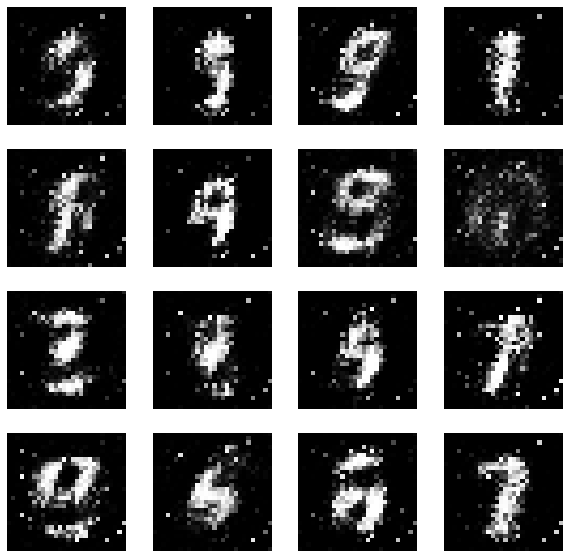

In [ ]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(to_pil_image(0.5*img_fake[i]+0.5),cmap='gray')
    plt.axis('off')